# Transport Results for SN junction

This notebook presents NEGF code to model a Superconductor-Normal metal (SN) junction. A thin insulating barrier is assumed to be present between the superconductor and the normal metal. 

The aim of this notebook is to match BTK results obtained using scattering theory.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special

# The SN junction is modelled using a tight-binding Hamiltonian in one dimension
# The function presented here is more general and can be used for finite cross section nanowires
def create_Hamiltonian(dimensions,physical_parameters):
    '''
    dimensions : dictionary with the following three numbers,
        N_lat : number of points laterally
        N_z : number of points in the z direction
        N_int : number of internal degrees of freedom = 1,2,4
    physical_paramters : dictionary with the revelant physical parameters
    '''
    N_lat = dimensions['N_lat']
    N_z = dimensions['N_z']
    N_int = dimensions['N_int']
    
    t = physical_parameters['t']
    Delta = physical_parameters['Delta']
    mu = physical_parameters['mu']
    
    # Hamiltonian element functions
    def create_alpha(ind):
        if N_int == 1:
            alpha = 2*t - mu
        elif N_int == 2:
            alpha = np.array([[2*t-mu,Delta],[np.conj(Delta),-2*t+mu]])
        
        return alpha

    def create_beta(ind1,ind2):
        if N_int == 1:
            beta = -t
        elif N_int == 2:
            beta = np.array([[-t,0],[0,t]])
    
        return beta

    def create_zero():
        if N_int == 1:
            return 0.0
        elif N_int == 2:
            return np.zeros((2,2))
    
    def func_H(ind1,ind2):
        if ind1 == ind2:
            return create_alpha(ind1)
        elif tuple(abs(x) for x in tuple(i-j for i,j in zip(ind1,ind2))) \
        in [(0,0,1),(0,1,0),(1,0,0)]:
            return create_beta(ind1,ind2)
        else:
            return create_zero()

    # list of space indices of the Hamiltonian    
    indices = list(itertools.product(range(N_lat),range(N_lat),range(N_z)))
    H = [func_H(ind1,ind2) for ind1,ind2 in itertools.product(indices, indices)]

    N = N_lat*N_lat*N_z

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,N_int,N_int))
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(N_int*N,N_int*N)

    return H_mat

We now test the function to $\text{create_Hamiltonian}$.

In [13]:
dimensions = {'N_z' : 3,'N_lat' : 1,"N_int" : 2}
physical_parameters = {'t' : 1.0,'Delta' : 1e-2,'mu' : 0.0}

H_mat = create_Hamiltonian(dimensions,physical_parameters)
print(H_mat)

[[ 2.00+0.j  0.01+0.j -1.00+0.j  0.00+0.j  0.00+0.j  0.00+0.j]
 [ 0.01+0.j -2.00+0.j  0.00+0.j  1.00+0.j  0.00+0.j  0.00+0.j]
 [-1.00+0.j  0.00+0.j  2.00+0.j  0.01+0.j -1.00+0.j  0.00+0.j]
 [ 0.00+0.j  1.00+0.j  0.01+0.j -2.00+0.j  0.00+0.j  1.00+0.j]
 [ 0.00+0.j  0.00+0.j -1.00+0.j  0.00+0.j  2.00+0.j  0.01+0.j]
 [ 0.00+0.j  0.00+0.j  0.00+0.j  1.00+0.j  0.01+0.j -2.00+0.j]]


In order to calculate the current from device Hamiltoninan, the leads at the two ends have to be taken into account. The surface Green's function of the semi-infinite leads is calculated in an iterative fashion, taking into account the infinite nature of the lead Hamiltonian.

In mathematical terms, the surface Green's function $g_s$,
$$g_s = ((E + 1i \eta) - \alpha - 
\beta g_s \beta^{\dagger})^{-1}$$

The leads are kept at chemical potentials $\mu_1$ and $\mu_2$. The device chemical potential $\mu$ is assumed to be equal to the average of the lead potentials ($\mu = \frac{\mu_1 + \mu_2}{2}$). 

In [156]:
def current_E(E,dimensions, physics):
    # dimensions
    N_lat = dimensions['N_lat']
    N_z =  dimensions['N_z']
    N_int = dimensions['N_int']
  
    # create the local variables
    eta = physics['eta']
    kT = physics['kT']
    mu_1 = physics['mu_1']
    mu_2 = physics['mu_2']
    mu = 0.5*(mu_1 + mu_2)
    
    # create the physical paramters dictionaries to create the respective Hamiltonians for S1-N-S2
    physical_parameters_N = {'t' : physics['t'],'Delta' : 0.0,'mu' : mu}
    physical_parameters_S_1 = {'t' : physics['t'],'Delta' : physics['Delta_1'],'mu' : mu} 
    physical_parameters_S_2 = {'t' : physics['t'],'Delta' : physics['Delta_2'],'mu' : mu}
    
    
    def surface_g(E,physical_parameters):
        # create a dummy Hamiltonian with two layers to get the hopping element beta and the layer element alpha
        
        dummy_dimensions = dimensions.copy()
        dummy_dimensions['N_z'] = 2
        
        H_mat = create_Hamiltonian(dummy_dimensions,physical_parameters)

        N_dof_lat = N_lat*N_lat*N_int

        alpha = H_mat[:N_dof_lat,:N_dof_lat]
        beta = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        err = 1.0
        iter_count = 0
        iter_limit = 100000
        err_limit = 1e-3

        g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        g_old = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        # iterate over iter_limit iterations or until err < err_limit
        for i in range(iter_limit):
            g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(beta,g),beta))
            g = 0.5*(g + g_old)

            err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
            g_old = g
            if(err < err_limit):
                #print("Finished at",i,"Error :",err)
                break;
            if(i == (iter_limit - 1)):
                print("iter_limit hit in calculation of surface_g",err)
        return g
    
    g_1 = surface_g(E,physical_parameters_S_1)
    g_2 = surface_g(E,physical_parameters_S_2)
    
    H_mat = create_Hamiltonian(dimensions,physical_parameters_N)
    
    #number of dof in a layer
    N_dof_lat = N_lat*N_lat*N_int
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.dot(np.dot(beta_layer,g_1),beta_layer)
    sigma_mini_2 = np.dot(np.dot(beta_layer,g_2),beta_layer)
    
    sigma_1 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.conj(sigma_1).T)
    
    sigma_2 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.conj(sigma_2).T)    
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT,N_int):
        if N_int == 1:
            return fermi(E-mu,kT)
        elif N_int == 2:
            return np.array([[fermi(E - mu,kT),0],[0,fermi(E + mu,kT)]])
        
    F1 = np.kron(np.eye(N_lat*N_lat*N_z),generate_fermi_matrix(E,mu_1-mu,kT,N_int))
    F2 = np.kron(np.eye(N_lat*N_lat*N_z),generate_fermi_matrix(E,mu_2-mu,kT,N_int))
    
    sigma_in = np.dot(gamma_1,F1) + np.dot(gamma_2,F2)

    G = np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.conj(G).T)
    
    G_n = np.dot(np.dot(G,sigma_in),np.conj(G).T)
    
    I_mat = 1j*(np.dot(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
            - np.dot(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    # current = electron current - hole current
    I = 2*I_mat[0,0] 
    return I

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


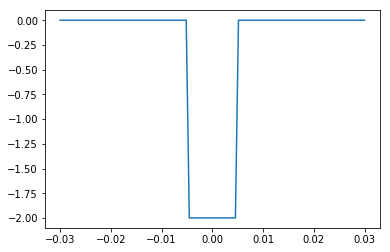

In [158]:
dV = 1e-2
dimensions = {'N_lat' : 1,
              'N_z'   : 2,
              'N_int' : 2
}

physics = {'eta'     : 1e-8,
           't'       : 1,
           'mu_1'    : 2 + dV,
           'mu_2'    : 2,
           'Delta_1' : 0e-2,            
           'Delta_2' : 1e-2,            
           'kT'      : 1e-6
}

E_linspace = np.linspace(-3e-2,3e-2,100)
I_E = [current_E(E,dimensions,physics) for E in E_linspace]
plt.plot(E_linspace,I_E);

In [ ]:
# Actual numerical simulation
import scipy.integrate
def I_V(dV):
    dimensions = {'N_lat' : 1,
                  'N_z'   : 2,
                  'N_int' : 2
    }

    physics = {'eta'     : 1e-8,
               't'       : 1,
               'mu_1'    : 2,
               'mu_2'    : 2 + dV,
               'Delta_1' : 0,            
               'Delta_2' : 0.5e-2,            
               'kT'      : 1e-6
    }


    
    #I = np.sum(np.array(I_E))
    
    import scipy.integrate
    t = physics['t']
    I = scipy.integrate.quad(lambda x: current_E(x,dimensions,physics),-1.5*abs(dV),1.5*abs(dV))
    return I

N_v = 25
dV = np.linspace(0,3e-2,N_v)
import time
st = time.time()
I_vec = np.array([I_V(x)[0] for x in dV])
print(time.time()-st)
plt.plot(dV,I_vec)

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


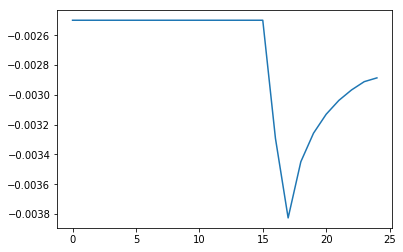

In [161]:
plt.plot(-np.gradient(I_vec))